# CMPS 4010
## Milestone 3: Naive Model to Predict Volatility
### By Alex Olteanu and Shira Rozenthal

### Next steps

- Aggregate Features: For each stock and time_id pairing, extract aggregated features such as average price, total volume, volatility, spread between bid and ask prices, etc.


- Feature Engineering: Derive new features from the existing data columns. Some potential features to consider:
  - Moving averages of prices.
  - Momentum and rate of change indicators.
  - Order book imbalance (difference between bid and ask volumes).
  - Rolling volatility or standard deviation.
  - Price jumps or gaps between consecutive time buckets.

- K-means Clustering: Use the K-means algorithm to cluster time_ids based on the extracted features to identify similar market conditions.

- Reverse Engineer time_ids: Investigate the exact dates and times for each stock and time_id pairing. Integrate with historical data from platforms like Yahoo Finance.

### Setup

In [1]:
# ALEX CELL: Load the data.
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/My Drive/Tulane/CS/CMPS-4010/Milestones/optiver-realized-volatility-prediction/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1DoZUk_FnkQR4z_AuHH3E7aPqa-ZezMKV/Milestones/optiver-realized-volatility-prediction


In [2]:
# # # SHIRA CELL: Load the data.
# from google.colab import drive

# drive.mount('/content/drive')

# %cd /content/drive/My Drive/TULANE/FALL2023/CMPS4010/Milestones/optiver-realized-volatility-prediction/

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import r2_score
import glob
import time
from sklearn.manifold import TSNE
from sklearn.preprocessing import minmax_scale
from joblib import Parallel, delayed
from contextlib import contextmanager

%matplotlib inline

### Tutorial Notebook Imports

In [4]:
# Load and peek train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [6]:
test.head()

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [7]:
# Load and peek book and trade data for stock with id of 0
stock_id = 0

book_example = pd.read_parquet('book_train.parquet/stock_id=0')
trade_example = pd.read_parquet('trade_train.parquet/stock_id=0')

In [8]:
book_example.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100


In [9]:
trade_example.head()

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


In [10]:
# Load and peek book and trade data of df with stock id of 0 and time_id of 5
book_example = book_example[book_example['time_id']==5]
book_example.loc[:,'stock_id'] = stock_id

trade_example = trade_example[trade_example['time_id']==5]
trade_example.loc[:,'stock_id'] = stock_id

<ipython-input-10-5fa75afcb626>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_example.loc[:,'stock_id'] = stock_id
<ipython-input-10-5fa75afcb626>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_example.loc[:,'stock_id'] = stock_id


In [11]:
book_example.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [12]:
trade_example.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [13]:
# Generate a WAP feature for example book df
book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +
                                book_example['ask_price1'] * book_example['bid_size1']) / (
                                       book_example['bid_size1']+ book_example['ask_size1'])

In [14]:
# Plot WAP values for each second interval/observation in time bucket 5
fig = px.line(book_example, x="seconds_in_bucket", y="wap", title='WAP of stock_id_0, time_id_5')
fig.show()

In [15]:
# Define function for computing log returns
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

In [16]:
# Generate a log return feature for example book df
# Takes the log return of row x and row x-1
# Row zero omitted because it cannot be compared to a previous time entry using ~ operator
book_example.loc[:,'log_return'] = log_return(book_example['wap'])
book_example = book_example[~book_example['log_return'].isnull()]

In [17]:
# Plot log returns for each second interval/observation in time bucket 5
fig = px.line(book_example, x="seconds_in_bucket", y="log_return", title='Log return of stock_id_0, time_id_5')
fig.show()

In [18]:
# Define a function to compute realized volatility using the log returns in a time bucket
# Computed by taking the square root of the sum of squared log returns
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

realized_vol = realized_volatility(book_example['log_return'])
print(f'Realized volatility for stock_id 0 on time_id 5 is {realized_vol}')

Realized volatility for stock_id 0 on time_id 5 is 0.004499364172786558


In [19]:
# Create a list of all file paths within book training parquet file
list_order_book_file_train = glob.glob('book_train.parquet/*')

list_order_book_file_train

['book_train.parquet/stock_id=5',
 'book_train.parquet/stock_id=53',
 'book_train.parquet/stock_id=98',
 'book_train.parquet/stock_id=2',
 'book_train.parquet/stock_id=31',
 'book_train.parquet/stock_id=62',
 'book_train.parquet/stock_id=96',
 'book_train.parquet/stock_id=97',
 'book_train.parquet/stock_id=63',
 'book_train.parquet/stock_id=55',
 'book_train.parquet/stock_id=38',
 'book_train.parquet/stock_id=36',
 'book_train.parquet/stock_id=64',
 'book_train.parquet/stock_id=90',
 'book_train.parquet/stock_id=4',
 'book_train.parquet/stock_id=99',
 'book_train.parquet/stock_id=3',
 'book_train.parquet/stock_id=122',
 'book_train.parquet/stock_id=125',
 'book_train.parquet/stock_id=39',
 'book_train.parquet/stock_id=30',
 'book_train.parquet/stock_id=114',
 'book_train.parquet/stock_id=52',
 'book_train.parquet/stock_id=37',
 'book_train.parquet/stock_id=112',
 'book_train.parquet/stock_id=115',
 'book_train.parquet/stock_id=113',
 'book_train.parquet/stock_id=124',
 'book_train.parq

In [20]:
# Define a function for computing the realitized volatiltiy for each time bucket for a specific stock
def realized_volatility_per_time_id(file_path, prediction_column_name):
    # Load the parquet file for a specific stock into a DataFrame
    df_book_data = pd.read_parquet(file_path)

    # Compute the Weighted Average Price (WAP) using bid and ask prices and sizes
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data['ask_size1'])

    # Calculate the log returns of WAP for each 'time_id'
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)

    # Remove rows with NaN values in the 'log_return' column
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]

    # Compute the realized volatility for each 'time_id' based on the log returns
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()

    # Rename the 'log_return' column to the provided prediction_column_name
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})

    # Extract the stock_id from the file_path
    stock_id = file_path.split('=')[1]

    # Create a 'row_id' column combining the stock_id and time_id
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')


    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

In [21]:
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    # Initialize an empty DataFrame to store the results for all stocks
    df_past_realized = pd.DataFrame()

    # Loop through each file in the provided list (each file corresponds to a stock's data)
    for file in list_file:
        # Compute the realized volatility for the current stock using the function 'realized_volatility_per_time_id'
        # This function returns the realized volatility for each 'time_id' of the current stock
        df_single_stock_realized_vol = realized_volatility_per_time_id(file, prediction_column_name)

        # Concatenate the results for the current stock with the aggregated results
        df_past_realized = pd.concat([df_past_realized, df_single_stock_realized_vol])

    # Return the aggregated results for all stocks
    return df_past_realized

# Calculate the realized volatility for all stocks in the training data
# The list 'list_order_book_file_train' contains file paths for all stocks in the training set
df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train, prediction_column_name='pred')

<ipython-input-20-27fa7e15577d>:11: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

<ipython-input-20-27fa7e15577d>:11: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

<ipython-input-20-27fa7e15577d>:11: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the fu

In [22]:
df_past_realized_train.head()

,row_id,pred
0,5-5,0.005366
1,5-11,0.001776
2,5-16,0.002458
3,5-31,0.004464
4,5-62,0.002807


In [23]:
train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


In [24]:
# Create a new column 'row_id' in the 'train' dataframe. This column is a combination of the 'stock_id' and 'time_id' columns.
# The two values are separated by a '-' and both are converted to string type to facilitate concatenation.
train_mod = pd.read_csv('train.csv')

train_mod['row_id'] = train['stock_id'].astype(str) + '-' + train_mod['time_id'].astype(str)

# Update the 'train' dataframe to keep only the 'row_id' and 'target' columns.
train_mod = train_mod[['row_id','target']]

# Merge the 'train' dataframe with the 'df_past_realized_train' dataframe.
# The merging is based on the 'row_id' column, which is common between the two dataframes.
# This is a left merge, which means all the rows from the 'train' dataframe will be retained and corresponding
# values from 'df_past_realized_train' will be added wherever there's a match based on 'row_id'.
# If there's no match for a particular 'row_id' in 'df_past_realized_train', NaN values will be filled for 'pred' column.
df_joined = train_mod.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'left')

In [25]:
train_mod

,row_id,target
0,0-5,0.004136
1,0-11,0.001445
2,0-16,0.002168
3,0-31,0.002195
4,0-62,0.001747
...,...,...
428927,126-32751,0.003461
428928,126-32753,0.003113
428929,126-32758,0.004070
428930,126-32763,0.003357


In [26]:
df_joined

,row_id,target,pred
0,0-5,0.004136,0.004499
1,0-11,0.001445,0.001204
2,0-16,0.002168,0.002369
3,0-31,0.002195,0.002574
4,0-62,0.001747,0.001894
...,...,...,...
428927,126-32751,0.003461,0.003691
428928,126-32753,0.003113,0.004104
428929,126-32758,0.004070,0.003117
428930,126-32763,0.003357,0.003661


In [27]:
from sklearn.metrics import r2_score

# Define a function to calculate the Root Mean Squared Percentage Error (RMSPE)
def rmspe(y_true, y_pred):
    # The formula for RMSPE is the square root of the average of squared percentage errors.
    # The percentage error is calculated as (actual - predicted) / actual, squared to penalize larger errors.
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

# Calculate the R^2 score using the true target values and the predicted values from the 'df_joined' dataframe.
# The R^2 score measures the proportion of the variance in the dependent variable that is predictable from the independent variables.
# It provides a measure of how well the observed outcomes are replicated by the model.
R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)

# Calculate the RMSPE using the true target values and the predicted values from the 'df_joined' dataframe.
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)

# Print out the calculated R^2 score and RMSPE.
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive prediction: R2 score: 0.628, RMSPE: 0.341


### EDA

In [28]:
# Define functions for readily extracting layers of the parquet file
def read_parquet_file(data_type, stock_id):
    file_path = f'{data_type}_train.parquet/stock_id={stock_id}'
    return pd.read_parquet(file_path)

def filter_data(df, time_id=None, seconds_in_bucket=None):
    if time_id:
        df = df[df['time_id'] == time_id]
    if seconds_in_bucket:
        df = df[df['seconds_in_bucket'] == seconds_in_bucket]
    return df

def extract_data(data_type, stock_id, time_id=None, seconds_in_bucket=None):
    if data_type not in ['book', 'trade']:
        raise ValueError("data_type should be either 'book' or 'trade'")

    df = read_parquet_file(data_type, stock_id)

    df = filter_data(df, time_id, seconds_in_bucket)

    return df

In [29]:
df_book_test = extract_data('book', 1, 5, 10)
#df_book_test

df_book_test2 = extract_data('book', 1, 5)
#df_book_test2

df_book_test3 = extract_data('book', 1)
#df_book_test3

df_trade_test = extract_data('trade', 1, 5, 28)
#df_trade_test

df_trade_test2 = extract_data('trade', 1, 5)
#df_trade_test2

df_trade_test3 = extract_data('trade', 1)
#df_trade_test3

In [30]:
stock_ids = sorted([file.split('=')[-1] for file in list_order_book_file_train], key=int)

print(f"Number of unique stocks: {len(stock_ids)}")
print(f"Stock ids: {stock_ids}")

Number of unique stocks: 112
Stock ids: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '46', '47', '48', '50', '51', '52', '53', '55', '56', '58', '59', '60', '61', '62', '63', '64', '66', '67', '68', '69', '70', '72', '73', '74', '75', '76', '77', '78', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '118', '119', '120', '122', '123', '124', '125', '126']


In [31]:
sample_data = read_parquet_file('book', 90)

In [32]:
unique_time_ids = sample_data['time_id'].unique()
print(f"\nNumber of unique time ids: {len(unique_time_ids)}")
print(f"Unique time ids: {unique_time_ids}")


Number of unique time ids: 3830
Unique time ids: [    5    11    16 ... 32758 32763 32767]


In [33]:
unique_seconds = sample_data['seconds_in_bucket'].unique()
print(f"\nNumber of unique seconds in a time bucket: {len(unique_seconds)}")
print(f"Unique seconds values: {sorted(unique_seconds)}")


Number of unique seconds in a time bucket: 600
Unique seconds values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207

In [ ]:
consistent_time_ids = True
consistent_seconds = True

for stock_id in stock_ids[1:10]:
    data = read_parquet_file('book', stock_id)

    if not set(unique_time_ids) == set(data['time_id'].unique()):
        consistent_time_ids = False

    if not set(unique_seconds) == set(data['seconds_in_bucket'].unique()):
        consistent_seconds = False

    if not (consistent_time_ids and consistent_seconds):
        break

print(f"\nTime ids are consistent across stocks: {consistent_time_ids}")
print(f"Seconds in bucket values are consistent across stocks: {consistent_seconds}")


Time ids are consistent across stocks: True
Seconds in bucket values are consistent across stocks: True


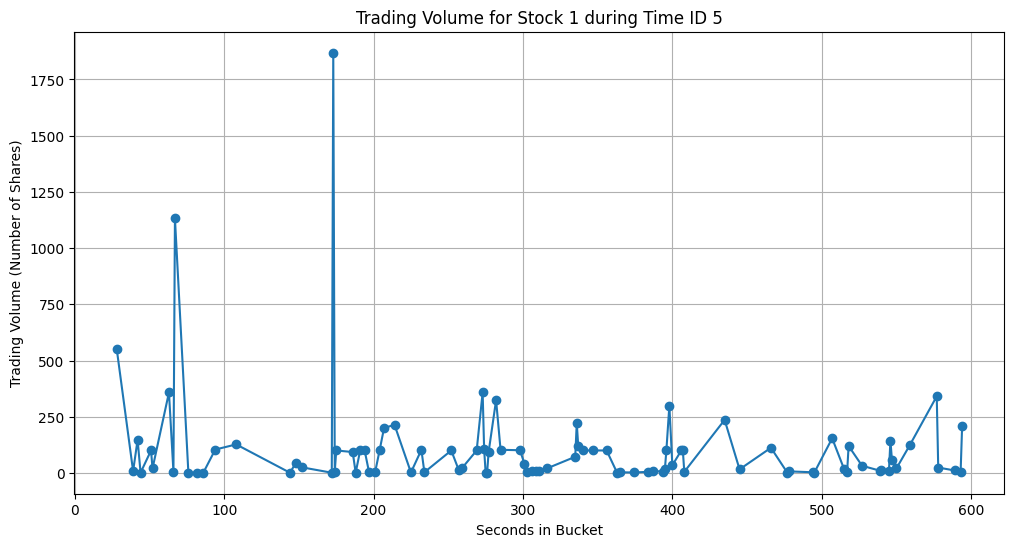

In [ ]:
def plot_trading_volume(stock_id, time_id):
    trade_data = extract_data(data_type='trade', stock_id=stock_id)

    trade_data_time_id = trade_data[trade_data['time_id'] == time_id]

    plt.figure(figsize=(12, 6))
    plt.plot(trade_data_time_id['seconds_in_bucket'], trade_data_time_id['size'], marker='o', linestyle='-')
    plt.title(f'Trading Volume for Stock {stock_id} during Time ID {time_id}')
    plt.xlabel('Seconds in Bucket')
    plt.ylabel('Trading Volume (Number of Shares)')
    plt.grid(True)
    plt.show()

plot_trading_volume(stock_id=1, time_id=5)

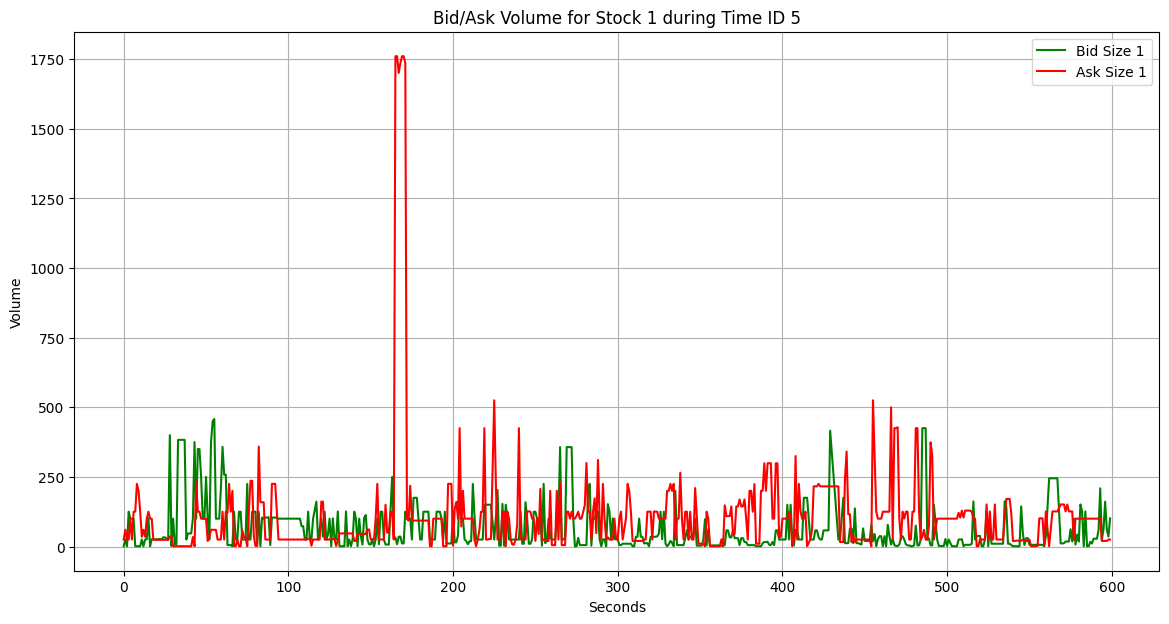

In [ ]:
def plot_bid_ask_volume(stock_id, time_id):
    book_data = extract_data('book', stock_id, time_id)

    plt.figure(figsize=(14, 7))
    plt.plot(book_data['seconds_in_bucket'], book_data['bid_size1'], label='Bid Size 1', color='green')
    plt.plot(book_data['seconds_in_bucket'], book_data['ask_size1'], label='Ask Size 1', color='red')

    plt.title(f'Bid/Ask Volume for Stock {stock_id} during Time ID {time_id}')
    plt.xlabel('Seconds')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_bid_ask_volume(stock_id=1, time_id=5)

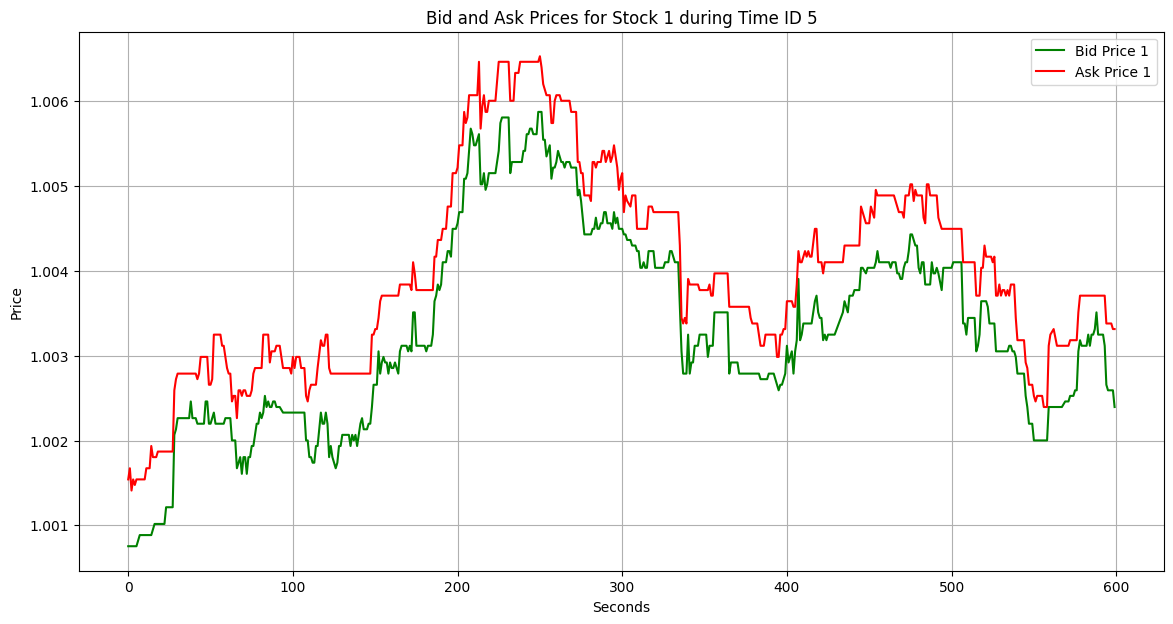

In [ ]:
def plot_bid_ask_price(stock_id, time_id):
    book_data = extract_data('book', stock_id, time_id)

    plt.figure(figsize=(14, 7))

    plt.plot(book_data['seconds_in_bucket'], book_data['bid_price1'], label='Bid Price 1', color='green')
    plt.plot(book_data['seconds_in_bucket'], book_data['ask_price1'], label='Ask Price 1', color='red')

    plt.title(f'Bid and Ask Prices for Stock {stock_id} during Time ID {time_id}')
    plt.xlabel('Seconds')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_bid_ask_price(stock_id=1, time_id=5)

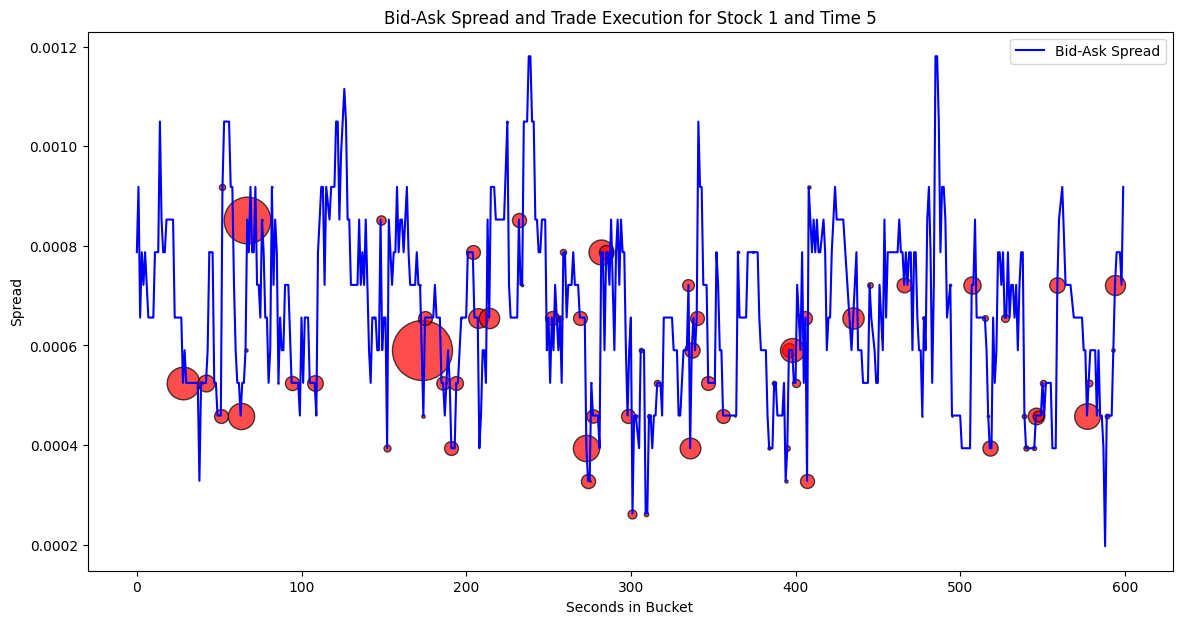

In [ ]:
def visualize_spread_and_trades(stock_id, time_id):
    book_data = extract_data('book', stock_id, time_id)
    trade_data = extract_data('trade', stock_id, time_id)

    book_data['spread'] = book_data['ask_price1'] - book_data['bid_price1']

    plt.figure(figsize=(14, 7))
    plt.plot(book_data['seconds_in_bucket'], book_data['spread'], label='Bid-Ask Spread', color='blue')

    for _, row in trade_data.iterrows():
        color = 'red' if row['price'] > book_data.loc[book_data['seconds_in_bucket'] == row['seconds_in_bucket'], 'bid_price1'].values[0] else 'green'
        plt.scatter(row['seconds_in_bucket'], book_data.loc[book_data['seconds_in_bucket'] == row['seconds_in_bucket'], 'spread'].values[0],
                    s=row['size'],
                    color=color,
                    edgecolors='black',
                    alpha=0.7)

    plt.title(f'Bid-Ask Spread and Trade Execution for Stock {stock_id} and Time {time_id}')
    plt.xlabel('Seconds in Bucket')
    plt.ylabel('Spread')
    plt.legend()
    plt.show()

visualize_spread_and_trades(1, 5)

### Reversing Time-ID order

In [ ]:
@contextmanager
def timer(name):
    s = time.time()
    yield
    e = time.time() - s
    print(f"[{name}] {e:.3f}sec")


def calc_price2(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick


def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.set_index('time_id')
    df = df.groupby(level='time_id').apply(calc_price2).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df


def sort_manifold(df, clf):
    df_ = df.set_index('time_id')
    df_ = pd.DataFrame(minmax_scale(df_.fillna(df_.mean())))

    X_compoents = clf.fit_transform(df_)

    dft = df.reindex(np.argsort(X_compoents[:,0])).reset_index(drop=True)
    return np.argsort(X_compoents[:, 0]), X_compoents


def reconstruct_time_id_order():
    with timer('load files'):
        df_files = pd.DataFrame(
            {'book_path': glob.glob('book_train.parquet/**/*.parquet')}) \
            .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")', engine='python')

    with timer('calc prices'):
        df_prices = pd.concat(Parallel(n_jobs=4, verbose=51)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))
        df_prices = df_prices.pivot('time_id', 'stock_id', 'price')
        df_prices.columns = [f'stock_id={i}' for i in df_prices.columns]
        df_prices = df_prices.reset_index(drop=False)

    with timer('t-SNE(400) -> 50'):
        clf = TSNE(n_components=1, perplexity=400, random_state=0, n_iter=2000)
        order, X_compoents = sort_manifold(df_prices, clf)

        clf = TSNE(n_components=1, perplexity=50, random_state=0, init=X_compoents, n_iter=2000, method='exact')
        order, X_compoents = sort_manifold(df_prices, clf)

        df_ordered = df_prices.reindex(order).reset_index(drop=True)
        if df_ordered['stock_id=61'].iloc[0] > df_ordered['stock_id=61'].iloc[-1]:
            df_ordered = df_ordered.reindex(df_ordered.index[::-1]).reset_index(drop=True)

    # AMZN
    plt.plot(df_ordered['stock_id=61'])

    return df_ordered[['time_id']]

[load files] 0.094sec
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   15.7s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   16.4s
[Parallel(n_jobs=4)]: Done  15 tasks      | elaps

<ipython-input-39-5ed3c5d91c07>:40: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



[calc prices] 96.992sec
[t-SNE(400) -> 50] 1042.276sec


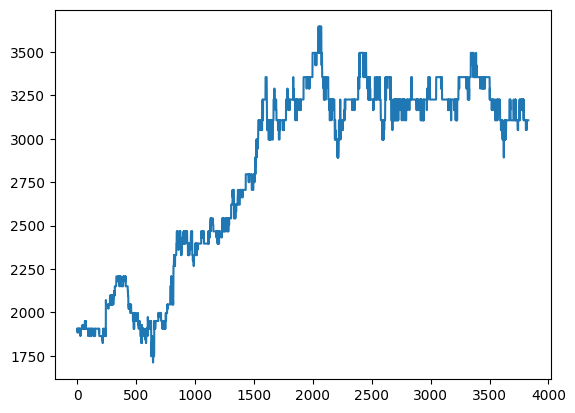

In [ ]:
df_ordered = reconstruct_time_id_order()

In [ ]:
df_ordered

,time_id
0,4294
1,24033
2,5666
3,29740
4,22178
...,...
3825,24913
3826,32195
3827,15365
3828,10890


### Feature Engineering

In [ ]:
extract_data('book',1,5)

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100
1,5,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100
2,5,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125
3,5,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36
4,5,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25
...,...,...,...,...,...,...,...,...,...,...
570,5,595,1.002592,1.003379,1.002460,1.003576,61,20,25,25
571,5,596,1.002592,1.003379,1.002460,1.003510,161,20,25,25
572,5,597,1.002592,1.003379,1.002460,1.003445,61,20,25,25
573,5,598,1.002592,1.003313,1.002460,1.003379,36,25,25,20


In [ ]:
def aggregate_features_per_time_id(file_path):
    # Load the parquet file for a specific stock into a DataFrame
    df_book_data = pd.read_parquet(file_path)

    # Aggregate features here:
    df_aggregated = df_book_data.groupby('time_id').agg({
        'bid_price1': 'mean',
        'ask_price1': 'mean',
        # Add more features as needed
    }).reset_index()

    # Extract the stock_id from the file_path
    stock_id = file_path.split('=')[1]

    # Add stock_id column
    df_aggregated['stock_id'] = stock_id

    return df_aggregated

def aggregate_features_for_all_stocks(list_file):
    df_aggregated_all = pd.DataFrame()
    for file in list_file:
        df_single_stock_aggregated = aggregate_features_per_time_id(file)
        df_aggregated_all = pd.concat([df_aggregated_all, df_single_stock_aggregated])

    return df_aggregated_all

# Get the aggregated features for all stocks in the training data
df_aggregated_train = aggregate_features_for_all_stocks(list_file=list_order_book_file_train)


### KNN Model